# Part 2: Connecting to Foursquare and Yelp APIs

## Imports

In [1]:
from datetime import datetime
import os
import pandas as pd

from utils import export, get

### Get API keys

In [2]:
foursquare_api_key: str = os.getenv('APIKEY_FOURSQUARE')
yelp_api_key: str = os.getenv('APIKEY_YELP')

## Read bike stations data

In [3]:
dirname = '../data/'
basename = 'stations.csv'
filename = dirname + basename

stations_df = pd.read_csv(filename, sep=',', index_col=False)
stations_df.head()

,timestamp,station_id,name,latitude,longitude,altitude,slots,free_bikes,empty_slots,has_ebikes,ebikes,normal_bikes
0,2024-05-03T15:29:29.800000Z,e1593acef03a0fd770595370586bc358,P31 - Estación Canal 13,-33.428334,-70.627312,0.0,13,6,7,True,0,6
1,2024-05-03T15:29:29.533000Z,3983dd515589a80338dd44a28f5ec414,V34 - Mestizo,-33.394000,-70.600000,0.0,23,8,15,True,0,8
2,2024-05-03T15:29:29.537000Z,405a3a5ca08c7536d3eb286cf8553025,V10 - Casa Costanera,-33.398000,-70.598000,0.0,11,8,3,True,0,8
3,2024-05-03T15:29:29.538000Z,0e8dfc3f137cb3911bd32f5fd45e0f93,V35 - Municipalidad de Vitacura,-33.398000,-70.601000,0.0,15,9,3,True,0,9
4,2024-05-03T15:29:29.539000Z,bdf4fc889476008ea8c644640f306bbc,V07 - Bicentenario,-33.401000,-70.602000,0.0,17,8,8,True,0,8


## Foursquare

### Send a request to Foursquare for each bike station in your city of choice 

In [4]:
def foursquare_search(
    latitude: float,
    longitude: float,
    radius: int,
    limit: int,
    api_key: str = foursquare_api_key
):
    """
    Return a get response from Foursquare's Place Search.

    Make a get request to Foursquare's Place Search using
    latitude, longitude, and radius. Accept a JSON response.

    :param latitude: latitude of a place
    :type latitude: float

    :param longitude: longitude of a place
    :type longitude: float

    :param radius: metres around a place considered nearby 
    :type radius: int

    :param limit: max number of results to include in response
    :type limit: int

    :param api_key: Foursquare API key
    :type api_key: str
    
    :return: a Place Search response from Foursquare
    :rtype: requests.Response | None    
    """
    # Foursquare Place Search endpoint
    url = 'https://api.foursquare.com/v3/places/search'

    params = {
        'll': f'{latitude},{longitude}',
        'radius': radius,
        'limit': limit
    }

    headers = {
        'accept': 'application/json',
        'authorization': foursquare_api_key
    }

    return get(url, params, headers)

In [5]:
def foursquare_results(
    stations_df: pd.DataFrame,
    row: int,
    radius: int = 500,
    limit: int = 10,
) -> list[dict] | None:
    """
    Return the results list from a Foursquare Place Search.

    Given a particular row, *i.e.,* a bike station, from the 
    stations_df DataFrame previously assembled, return a list 
    of places nearby the bike station in question. Return None
    if the Foursquare get request fails or if the request 
    succeeds but the corresponding response does not contain
    results.

    :param stations_df: bike stations data
    :type stations_df: DataFrame

    :param row: the number of a row in stations_df
    :type row: int

    :param radius: metres around a place considered nearby 
    :type radius: int

    :param limit: max number of results to include in response
    :type limit: int
    
    :return: the results list from a Foursqaure Place Search
    :rtype: list[dict]
    """
    station_id, lat, long =\
        stations_df.loc[row, ['station_id', 'latitude', 'longitude']].to_list()
    
    response = foursquare_search(lat, long, radius, limit)

    if response is None:
        return None

    data = response.json()

    try:
        results = data['results']
    except KeyError as err:
        print(f'response does not contain results, {err}')
        return None
    else:
        return results

Print out a single Foursquare result to get an idea of its structure.

In [6]:
tmp = foursquare_results(stations_df, row=0, radius=500, limit=1)
tmp[0]

{'fsq_id': '58dbe5d5126ae82bf8f7ff16',
 'categories': [{'id': 13322,
   'name': 'Peruvian Restaurant',
   'short_name': 'Peruvian',
   'plural_name': 'Peruvian Restaurants',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/peruvian_',
    'suffix': '.png'}}],
 'chains': [],
 'closed_bucket': 'Unsure',
 'distance': 163,
 'geocodes': {'main': {'latitude': -33.42865, 'longitude': -70.625766},
  'roof': {'latitude': -33.42865, 'longitude': -70.625766}},
 'link': '/v3/places/58dbe5d5126ae82bf8f7ff16',
 'location': {'admin_region': 'Santiago',
  'country': 'CL',
  'cross_street': '',
  'formatted_address': 'Providencia, Metropolitana de Santiago de Chile',
  'locality': 'Providencia',
  'region': 'Metropolitana de Santiago de Chile'},
 'name': 'Lima 17',
 'related_places': {},
 'timezone': 'America/Santiago'}

In [7]:
def result_to_place(
    stations_df: pd.DataFrame,
    result: dict, 
    row: int
) -> dict:
    """
    Return a dictionary of Foursquare place information.

    Given a particular result, *i.e.,* a place, extract the
    information that will be added to the foursquare_places_df
    DataFrame.

    :param stations_df: bike stations data
    :type stations_df: DataFrame
    
    :param result: a single result from a Foursquare Place Search
    :type result: dict

    :param row: the number of a row in stations_df
    :type row: int

    :return: a dictionary to be added as a row to a DataFrame
    :rtype: dict
    """
    return {
        'fsq_id': result.get('fsq_id'),
        'name': result.get('name'),
        'closed_bucket': result.get('closed_bucket'),
        'distance': result.get('distance'),
        'station_id': stations_df.loc[row, 'station_id']
    }

In [8]:
def result_to_categories(result: dict, row: int) -> list[dict]:
    """
    Return a dictionary of place category information.

    Given a particular result, *i.e.,* a place, extract all of
    its categories as a list that will be added to the 
    foursquare_categories_df DataFrame.

    :param result: a single result from a Foursquare Place Search
    :type result: dict

    :param row: the number of a row in stations_df
    :type row: int

    :return: a list of dictionaries to be added as rows to a DataFrame
    :rtype: dict
    """
    cat_list = []
    categories = result['categories']
    for category in categories:
        new_category = {
            'fsq_id': result.get('fsq_id'),
            'category_id': category.get('id'),
            'category_name': category.get('name')
        }
        cat_list.append(new_category)
    return cat_list

Initialize two lists intended to store dictionaries related to Foursquare places and categories.

In [9]:
foursquare_places = []
foursquare_categories = []

Loop through the rows of stations_df, parsing Foursquare Place Searches and extending foursquare_places and foursquare_categories on each iteration.

In [10]:
print(f'foursquare_places empty: {len(foursquare_places) == 0}')
print(f'foursquare_categories empty: {len(foursquare_categories) == 0}')
print('running...')
num_stations = stations_df.shape[0]
start = datetime.now()

for row in range(num_stations):
    results = foursquare_results(stations_df, row, radius=1000, limit=50)
    for result in results:
        new_places = result_to_place(stations_df, result, row)
        new_categories = result_to_categories(result, row)
        foursquare_categories += new_categories
        foursquare_places.append(new_places)

end = datetime.now()
runtime = end - start
print(f'...done after {runtime.seconds} s')

foursquare_places empty: True
foursquare_categories empty: True
running...
...done after 103 s


### Put the results into DataFrames

In [11]:
foursquare_places_df = pd.DataFrame(foursquare_places)
foursquare_places_df.head()

,fsq_id,name,closed_bucket,distance,station_id
0,58dbe5d5126ae82bf8f7ff16,Lima 17,Unsure,163,e1593acef03a0fd770595370586bc358
1,4bd9e4db3904a593501d449e,Plaza de la Aviación,VeryLikelyOpen,435,e1593acef03a0fd770595370586bc358
2,54e39d82498e2bf4dbe8df34,Starbucks,VeryLikelyOpen,417,e1593acef03a0fd770595370586bc358
3,50c5137fe4b02085d85e4047,Café del Negro,Unsure,410,e1593acef03a0fd770595370586bc358
4,59ad8e4228122f2d257f8772,Restaurant 47 Ronin,VeryLikelyOpen,498,e1593acef03a0fd770595370586bc358


In [12]:
foursquare_places_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9217 entries, 0 to 9216
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fsq_id         9217 non-null   object
 1   name           9217 non-null   object
 2   closed_bucket  9217 non-null   object
 3   distance       9217 non-null   int64 
 4   station_id     9217 non-null   object
dtypes: int64(1), object(4)
memory usage: 360.2+ KB


In [13]:
foursquare_categories_df = pd.DataFrame(foursquare_categories)
foursquare_categories_df.head()

,fsq_id,category_id,category_name
0,58dbe5d5126ae82bf8f7ff16,13322,Peruvian Restaurant
1,4bd9e4db3904a593501d449e,13065,Restaurant
2,4bd9e4db3904a593501d449e,16017,Garden
3,4bd9e4db3904a593501d449e,16032,Park
4,4bd9e4db3904a593501d449e,16041,Plaza


In [14]:
foursquare_categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11974 entries, 0 to 11973
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fsq_id         11974 non-null  object
 1   category_id    11974 non-null  int64 
 2   category_name  11974 non-null  object
dtypes: int64(1), object(2)
memory usage: 280.8+ KB


### Export the DataFrames to CSV

In [15]:
export(foursquare_places_df, 'foursquare_places.csv')
export(foursquare_categories_df, 'foursquare_categories.csv')

## Yelp

### Send a request to Yelp for each bike station in your city of choice

In [16]:
def yelp_search(
    latitude: float,
    longitude: float,
    radius: int,
    limit: int,
    api_key: str = yelp_api_key,
):
    """
    Return a get response from Yelp's Businesses Search.

    Make a get request to Yelp's Businesses Search using
    latitude, longitude, and radius. Accept a JSON response.

    :param latitude: latitude of a place
    :type latitude: float

    :param longitude: longitude of a place
    :type longitude: float

    :param radius: metres around a place considered nearby 
    :type radius: int

    :param limit: max number of results to include in response
    :type limit: int

    :param api_key: Yelp API key
    :type api_key: str
    
    :return: a Businesses Search response from Yelp
    :rtype: requests.Response | None    
    """
    # Yelp Businesses Search endpoint
    url = 'https://api.yelp.com/v3/businesses/search'

    params = {
        'latitude': latitude,
        'longitude': longitude,
        'radius': radius,
        'limit': limit
    }

    headers = {
        'accept': 'application/json',
        'authorization': f'Bearer {yelp_api_key}' 
    }

    return get(url, params=params, headers=headers)

In [17]:
def yelp_businesses(
    stations_df: pd.DataFrame, 
    row: int,
    radius: int = 500,
    limit: int = 10,
) -> list[dict] | None:
    """
    Return the results list from a Yelp Businesses Search.

    Given a particular row, *i.e.,* a bike station, from the 
    stations_df DataFrame previously assembled, return a list 
    of places nearby the bike station in question. Return None
    if the Yelp get request fails or if the request 
    succeeds but the corresponding response does not contain
    results.

    :param stations_df: bike stations data
    :type stations_df: DataFrame

    :param row: the number of a row in stations_df
    :type row: int

    :return: the results list from a Foursqaure Place Search
    :rtype: list[dict]
    """
    station_id, lat, long =\
        stations_df.loc[row, ['station_id', 'latitude', 'longitude']].to_list()
    
    response = yelp_search(lat, long, radius, limit)

    if response is None:
        return None

    data = response.json()

    try:
        results = data['businesses']
    except KeyError as err:
        print(f'response does not contain businesses, {err}')
        return None
    else:
        return results

Print out a single Yelp result to get an idea of its structure.

In [19]:
tmp = yelp_businesses(stations_df, row=0, radius=500, limit=1)
tmp[0]

{'id': 'kWQxKQrcn3PNHzxsdPALcw',
 'alias': 'jimbos-santiago-3',
 'name': "Jimbo's",
 'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/Xy6cPUzV-mMm_UUnQ-QsfA/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/jimbos-santiago-3?adjust_creative=63YPOQR85PnJzp_H-e7TYQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=63YPOQR85PnJzp_H-e7TYQ',
 'review_count': 3,
 'categories': [{'alias': 'australian', 'title': 'Australian'}],
 'rating': 4.7,
 'coordinates': {'latitude': -33.4286, 'longitude': -70.6258},
 'transactions': [],
 'location': {'address1': 'Los Pinones 29',
  'address2': None,
  'address3': '',
  'city': 'Santiago',
  'zip_code': '',
  'country': 'CL',
  'state': 'RM',
  'display_address': ['Los Pinones 29', 'RM Santiago', 'Chile']},
 'phone': '+56951266916',
 'display_phone': '+56 9 5126 6916',
 'distance': 151.5245960834386,
 'attributes': {'business_temp_closed': None,
  'menu_url': None,
  'open24_hours': None,
  'waitlist_reservation': Non

In [20]:
def result_to_business(
    stations_df: pd.DataFrame,
    result: dict, 
    row: int
) -> dict:
    """
    Return a dictionary of business information.

    Given a particular result, *i.e.,* a business, extract the
    information that will be added to the yelp_places_df
    DataFrame.

    :param stations_df: bike stations data
    :type stations_df: DataFrame
    
    :param result: a single result from a Yelp Businesses Search
    :type result: dict

    :param row: the number of a row in stations_df
    :type row: int

    :return: a dictionary to be added as a row to a DataFrame
    :rtype: dict
    """
    return {
        'yelp_id': result.get('id'),
        'name': result.get('name'),
        'is_closed': result.get('is_closed'),
        'review_count': result.get('review_count'),
        'price': result.get('price'),
        'rating': result.get('rating'),
        'distance': result.get('distance'),
        'station_id': stations_df.loc[row, 'station_id']
    }

In [21]:
def result_to_categories(result: dict, row: int) -> list[dict]:
    """
    Return a dictionary of place category information.

    Given a particular result, *i.e.,* a place, extract all of
    its categories as a list that will be added to the 
    foursquare_categories_df DataFrame.

    :param: a single result from a Foursquare Place Search
    :type: dict

    :param row: the number of a row in stations_df
    :type row: int

    :return: a list of dictionaries to be added as rows to a DataFrame
    :rtype: dict
    """
    return_list = []
    categories = result['categories']
    for category in categories:
        new_category = {
            'yelp_id': result['id'],
            'category_name': category['title']
        }
        return_list.append(new_category)
    return return_list

Initialize two lists to store information from Yelp on businesses and business categories.

In [22]:
yelp_places = []
yelp_categories = []

In [23]:
print(f'yelp_places empty: {len(yelp_places) == 0}')
print(f'yelp_categories empty: {len(yelp_categories) == 0}')
print('running...')
num_stations = stations_df.shape[0]
start = datetime.now()

for row in range(num_stations):
    results = yelp_businesses(stations_df, row, radius=1000, limit=50)
    for result in results:
        new_places = result_to_business(stations_df, result, row)
        new_categories = result_to_categories(result, row)
        yelp_categories += new_categories
        yelp_places.append(new_places)

end = datetime.now()
runtime = end - start
print(f'...done after {runtime.seconds} s')

yelp_places empty: True
yelp_categories empty: True
running...
...done after 194 s


### Put the results into DataFrames

In [24]:
yelp_places_df = pd.DataFrame(yelp_places)
yelp_places_df.head()

,yelp_id,name,is_closed,review_count,price,rating,distance,station_id
0,8N6Y3HsLXHBeFwhlO0YxwQ,Barrica 94,False,78,$$,4.3,988.631270,e1593acef03a0fd770595370586bc358
1,U15KdCy6HH05WISNtN9plQ,Restaurant Peumayén,False,73,$$$$,4.5,856.161401,e1593acef03a0fd770595370586bc358
2,y2FR-JBGie4wiW6RjtKLhg,Aquí Está Coco,False,58,$$$$,4.3,1099.691315,e1593acef03a0fd770595370586bc358
3,25PGm8dLZuar_Q0CZWK-dQ,Ciudad Vieja,False,27,$$,4.4,880.515212,e1593acef03a0fd770595370586bc358
4,x72iXJX0J7kibMpisppZ9g,Liguria Manuel Montt,False,27,$$$,3.8,775.050520,e1593acef03a0fd770595370586bc358


In [26]:
yelp_places_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10366 entries, 0 to 10365
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yelp_id       10366 non-null  object 
 1   name          10366 non-null  object 
 2   is_closed     10366 non-null  bool   
 3   review_count  10366 non-null  int64  
 4   price         7007 non-null   object 
 5   rating        10366 non-null  float64
 6   distance      10366 non-null  float64
 7   station_id    10366 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 577.1+ KB


In [27]:
yelp_categories_df = pd.DataFrame(yelp_categories)
yelp_categories_df.head()

,yelp_id,category_name
0,8N6Y3HsLXHBeFwhlO0YxwQ,Wine Bars
1,8N6Y3HsLXHBeFwhlO0YxwQ,Chilean
2,8N6Y3HsLXHBeFwhlO0YxwQ,Cocktail Bars
3,U15KdCy6HH05WISNtN9plQ,Latin American
4,y2FR-JBGie4wiW6RjtKLhg,Seafood


In [28]:
yelp_categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15181 entries, 0 to 15180
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   yelp_id        15181 non-null  object
 1   category_name  15181 non-null  object
dtypes: object(2)
memory usage: 237.3+ KB


### Export the DataFrames to CSV

In [29]:
export(yelp_places_df, 'yelp_places.csv')
export(yelp_categories_df, 'yelp_categories.csv')

## Comparing Results

### Which API provided you with more complete data? Provide an explanation. 

I would say that the Yelp data is more complete than the Foursquare data. Everything interesting that I pulled from the Foursquare data, *e.g.,* name, distance, closed_bucket, and categories, I also pulled from the Yelp data. But, with the Yelp data, there were additional potentially intersting pieces of information including review_count, price, and rating.

### Get the top 10 restaurants according to their rating

In [8]:
df = pd.merge(yelp_places_df, yelp_categories_df, how='inner', 
              on='yelp_id')

In [9]:
df.head()

,yelp_id,name,is_closed,review_count,price,rating,distance,station_id,category_name
0,8N6Y3HsLXHBeFwhlO0YxwQ,Barrica 94,False,78,$$,4.3,988.63127,e1593acef03a0fd770595370586bc358,Wine Bars
1,8N6Y3HsLXHBeFwhlO0YxwQ,Barrica 94,False,78,$$,4.3,988.63127,e1593acef03a0fd770595370586bc358,Chilean
2,8N6Y3HsLXHBeFwhlO0YxwQ,Barrica 94,False,78,$$,4.3,988.63127,e1593acef03a0fd770595370586bc358,Cocktail Bars
3,8N6Y3HsLXHBeFwhlO0YxwQ,Barrica 94,False,78,$$,4.3,988.63127,e1593acef03a0fd770595370586bc358,Wine Bars
4,8N6Y3HsLXHBeFwhlO0YxwQ,Barrica 94,False,78,$$,4.3,988.63127,e1593acef03a0fd770595370586bc358,Chilean


In [10]:
df[df['category_name'].str.lower().str.find('restaurant') >= 0]\
    .loc[:, ['yelp_id', 'name', 'rating', 'category_name']]\
    .drop_duplicates()\
    .sort_values('rating', ascending=False)\
    .head(10)

,yelp_id,name,rating,category_name
149429,EMLA3tBKy51OLZsJGY9XRg,Bali,5.0,Restaurants
65911,ZQTc_KRY-pa3CBQ4RYWxQA,El Rincón de La Mamita,5.0,Restaurants
167322,wx0gWn20HrqqMC-3h-zgZA,Sephia Restaurant,5.0,Restaurants
166755,zH3XTbRBA9nKcys3rnRvlQ,San Fabián de Alico,5.0,Restaurants
151680,z4AdfxFG34VaV4VN0rS64A,Motosandwich,5.0,Restaurants
167787,7HFodlhCsXncIJ4EjVePeA,Casona 1910,5.0,Restaurants
70167,bZ7JwRITJZyEVvqAGqSDng,Chilenazo,4.5,Restaurants
60956,PCttKQ438Mita6oKIvxucQ,Walhalla,4.5,Restaurants
167604,QYYkfgJ2t7O2r8M1a15jrg,Cuper & Co,4.5,Restaurants
167298,iVb-7H7pjmtDLP0viIiutQ,Ciro's,4.5,Restaurants


## Data Cleaning

### Load Datasets

For convenience, I include here the imports and data loading needed to make what follows self-contained. 

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from utils import export, get

In [12]:
dirname = '../data/'
stations_df = pd.read_csv(dirname + 'stations.csv', sep=',', index_col=False)
yelp_places_df = pd.read_csv(dirname + 'yelp_places.csv', sep=',', index_col=False)
yelp_categories_df = pd.read_csv(dirname + 'yelp_categories.csv', sep=',', index_col=False)

I take the following steps to clean the collected data:
  - remove irrelevant data
  - remove duplicate data
  - fix structural errors
  - convert types
  - handle missing data
  - deal with outliers
  - standardize/normalize data
  - validate data
  - encode data

#### Remove irrelevant data

Much of the process of removing irrelevant data was already handled during the data collection phase where I filtered out data from both CityBikes and Yelp that I didn't think would contribute to an interesting analysis. Printing out column lists for my DataFrames gives:

In [13]:
print(stations_df.columns)
print(yelp_places_df.columns)
print(yelp_categories_df.columns)

Index(['timestamp', 'station_id', 'name', 'latitude', 'longitude', 'altitude',
       'slots', 'free_bikes', 'empty_slots', 'has_ebikes', 'ebikes',
       'normal_bikes'],
      dtype='object')
Index(['yelp_id', 'name', 'is_closed', 'review_count', 'price', 'rating',
       'distance', 'station_id'],
      dtype='object')
Index(['yelp_id', 'category_name'], dtype='object')


As the data collected from CityBikes represents a snapshot in time, I'll drop the timestamp column for this particular analysis.

In [14]:
stations_df.drop('timestamp', axis='columns', inplace=True)

#### Remove duplicated data

In [15]:
print(stations_df.shape)
stations_df.drop_duplicates(inplace=True)
print(stations_df.shape)

(230, 11)
(230, 11)


In [16]:
print(yelp_places_df.shape)
yelp_places_df.drop_duplicates(inplace=True)
print(yelp_places_df.shape)

(10366, 8)
(10366, 8)


In [17]:
print(yelp_categories_df.shape)
yelp_categories_df.drop_duplicates(inplace=True)
print(yelp_categories_df.shape)

(15181, 2)
(2480, 2)


From the above before and after DataFrame shapes, there was no duplication in stations_df and yelp_places_df, but there was considerable duplication in yelp_categories_df. This is to be expected as a given business could, of course, be within 1 km of more than one bike station. Such businesses would generate more than one corresponding entry in yelp_categories_df.

#### Convert types

Checking the dtypes of all columns of all DataFrames:

In [18]:
stations_df.dtypes

station_id       object
name             object
latitude        float64
longitude       float64
altitude        float64
slots             int64
free_bikes        int64
empty_slots       int64
has_ebikes         bool
ebikes            int64
normal_bikes      int64
dtype: object

In [19]:
yelp_places_df.dtypes

yelp_id          object
name             object
is_closed          bool
review_count      int64
price            object
rating          float64
distance        float64
station_id       object
dtype: object

In [20]:
yelp_categories_df.dtypes

yelp_id          object
category_name    object
dtype: object

I conclude that all dtypes are appropriate. No conversions are needed.

#### Fix structural errors

In this cleaning step, I searched my three DataFrames for strange naming conventions, obvious typos, or inconsistencies in capitalization.

In [21]:
stations_df.sample(5)

,station_id,name,latitude,longitude,altitude,slots,free_bikes,empty_slots,has_ebikes,ebikes,normal_bikes
128,abc5c56a2aa51a6541cfb03b17dd3aee,LC025 - Noruega,-33.402891,-70.562093,0.0,11,5,6,True,0,5
27,78fc95854f6c1643f5902b7cfc3e4d3a,P46 - Román Díaz,-33.433680,-70.620823,0.0,11,8,3,True,0,8
200,c560ed81fd684e176abe8fb531882b64,S27 - Teatinos / Huérfanos,-33.439790,-70.655155,0.0,17,6,11,True,0,6
124,bde0622e2e2c885c602ddc359b7115ee,LC036 - Las Condes / Valle Alegre,-33.378284,-70.528372,0.0,11,6,5,True,0,6
154,054305243a7de00167a98a4c5a5e380a,P30 - Lo Contador,-33.420188,-70.618145,0.0,23,6,17,True,0,6


In [22]:
yelp_places_df.sample(5)

,yelp_id,name,is_closed,review_count,price,rating,distance,station_id
9241,z7K-cO48n1IYYbwTq7D6FQ,Soler,False,3,$$,4.0,597.843036,18538b14344aae003e57364b0d41f384
6019,D7aZ9ZGpnyObEawvMsXi_A,Liguria,False,29,$$,4.1,628.930394,241752702561661929a628a382ab6011
9262,09XfKLTkHeukEBknM8B_dA,Madam Tusan,False,15,$$,4.3,804.218372,06710a31e4139e53ba764baa9945e0d1
5634,ahdYi1-EETGEQjRGY9NcVg,Statuos quo bar,False,1,$$,5.0,601.009476,83445c6eb45e197f6fa40f9446ae0dcc
1139,t_k3q-ab51FLZ7TeIAGXHQ,El Rápido,False,14,$,4.1,710.044668,61e752fc3dc6b09e9de81044c5d46877


In [23]:
yelp_categories_df.sample(5)

,yelp_id,category_name
4293,A2_HFPnKq_rqyYz-oh51UA,Landmarks & Historical Buildings
146,0hDz3AfRgQBNLVbmb-jXZw,Cocktail Bars
9530,aZVvgHJWYzQWyS3IrmCccQ,Peruvian
12915,OfBqoZEcJ19juckp1scVBw,Coffee & Tea
5189,TMjTvn1SjTokSfXOkyrrCQ,Mediterranean


The only potential issue I see is the category_name column from yelp_categories. I anticipate performing aggregations on this column. Given that the column entries are strings, it is a good idea to ensure that they all have a common format. I'll convert them all to lower case and trim leading and/or trailing white space. Also, I'll replace all internal white space by a single space character.

In [29]:
def trim_ws_and_lower(s: str) -> str:
    """
    Return a lower case, whitespace-trimmed version of s.
    
    Usage examples:
    >>> trim_ws_and_lower('  SoMe    wordS  ')
    'some words'
    """
    return re.sub(r'\s+', ' ', s.lower().strip())

In [30]:
yelp_categories_df['category_name'] =\
    yelp_categories_df['category_name'].apply(lower_and_strip)

#### Handle missing data

I'll check to see which columns of my DataFrames have missing (or NA) values.

In [32]:
def pct_missing(df: pd.DataFrame, axis: int) -> pd.Series:
    """
    Return a Series of numbers of missing values as percentages.

    :param df: a DataFrame to check for missing values
    :type df: DataFrame

    :param axis: 0 for column means, 1 for row means
    :type axis: int

    :return: a Series of numbers of missing values as percentages
    :rtype: Series
    """
    return 100 * df.isna().sum(axis=axis) / df.shape[axis]

In [33]:
pct_missing(stations_df, 0)

station_id      0.0
name            0.0
latitude        0.0
longitude       0.0
altitude        0.0
slots           0.0
free_bikes      0.0
empty_slots     0.0
has_ebikes      0.0
ebikes          0.0
normal_bikes    0.0
dtype: float64

In [34]:
pct_missing(yelp_places_df, 0)

yelp_id          0.000000
name             0.000000
is_closed        0.000000
review_count     0.000000
price           32.404013
rating           0.000000
distance         0.000000
station_id       0.000000
dtype: float64

In [35]:
pct_missing(yelp_categories_df, 0)

yelp_id          0.0
category_name    0.0
dtype: float64

I conclude that the only column with missing values is prices of `yelp_places_df`: 32.4% of its entries are missing. I have no way of filling in this missing data. In analyses that take price into account, I will omit the corresponding rows where price is missing and work with a reduced data set.

### Deal with outliers

At this stage, I am interested in detecting and removing outliers that are **indicative of data entry or measurement errors.** 

To start, I'll generate an appropriate unary visualization or tabulation for the columns of my DataFrames in order to detect outliers and other problems with the data. Second, I'll develop a plan for data cleaning. Third, I'll execute the data-cleaning plan.

##### stations_df

In [36]:
stations_df.columns

Index(['station_id', 'name', 'latitude', 'longitude', 'altitude', 'slots',
       'free_bikes', 'empty_slots', 'has_ebikes', 'ebikes', 'normal_bikes'],
      dtype='object')

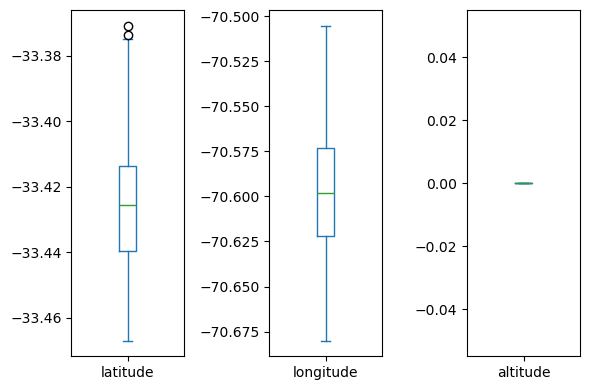

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
stations_df['latitude'].plot.box(ax=axes[0])
stations_df['longitude'].plot.box(ax=axes[1])
stations_df['altitude'].plot.box(ax=axes[2])
fig.tight_layout()

In [71]:
stations_df['altitude'].value_counts()

altitude
0.0    230
Name: count, dtype: int64

<Axes: >

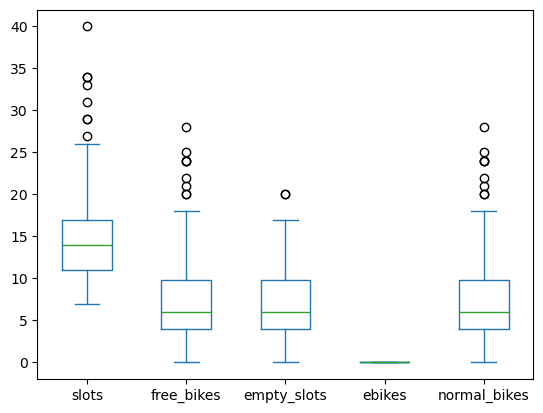

In [56]:
cols = ['slots', 'free_bikes', 'empty_slots', 'ebikes', 'normal_bikes']
stations_df[cols].plot.box()

In [82]:
stations_df['ebikes'].value_counts()

ebikes
0    230
Name: count, dtype: int64

In [84]:
(stations_df['free_bikes'] - stations_df['normal_bikes'] == 0)\
    .value_counts()

True    230
Name: count, dtype: int64

In [86]:
stations_df['has_ebikes'].value_counts()

has_ebikes
True    230
Name: count, dtype: int64

##### yelp_places_df

In [64]:
yelp_places_df.columns

Index(['yelp_id', 'name', 'is_closed', 'review_count', 'price', 'rating',
       'distance', 'station_id'],
      dtype='object')

In [87]:
yelp_places_df['is_closed'].value_counts()

is_closed
False    10366
Name: count, dtype: int64

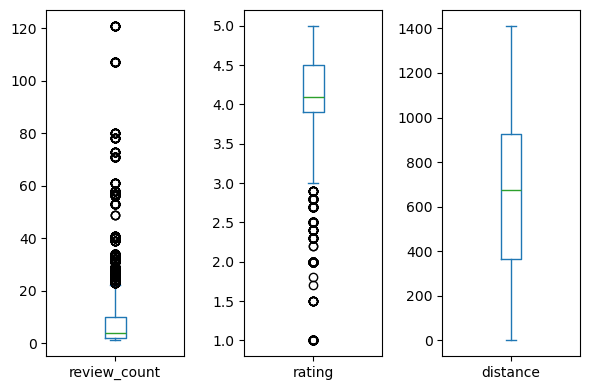

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
yelp_places_df['review_count'].plot.box(ax=axes[0])
yelp_places_df['rating'].plot.box(ax=axes[1])
yelp_places_df['distance'].plot.box(ax=axes[2])
fig.tight_layout()

In [96]:
yelp_places_df['price'].value_counts()

price
$$      4174
$$$     1473
$        941
$$$$     419
Name: count, dtype: int64

##### yelp_categories_df

In [61]:
yelp_categories_df.columns

Index(['yelp_id', 'category_name'], dtype='object')

In [63]:
yelp_categories_df['category_name'].nunique()

153

#### Data cleaning plan

From the above visualizations, I see that:
- There are two potential outliers in `stations_df['latitude']`. However, there's no reason to think that the corresponsing values are incorrect.
- The data in `stations_df['altitude']` are all zeroes which is incorrect. **I'll try to fill in this data from another source.**
- The entries in `stations['ebikes']` are all 0. If this is correct, it's uninteresting; if it's incorrect, I have no way of fixing it. **I'll delete this column.**
- Similarly, the `stations['has_ebikes']` column entries are all True. This is either correct but boring or incorrect and unfixable. **I'll delete this column.**
- The `stations_df['normal_bikes']` column is a duplicate of `stations_df['free_bikes']`. **I'll delete `stations['normal_bikes']`.**
- There are outliers in `stations_df['slots']`, `stations_df['free_bikes']`, and `stations_df['empty_slots']`. However, there's no reason to suspect that the corresponding values are errors. There just happen to be a handful of relatively large bike stations in Santiago.
- The `yelp_places_df['is_closed']` column entries are all False, unsurprising as the data was collected in early afternoon. **I'll delete this column.**
- There are several outliers in `yelp_places_df['review_count']` and `yelp_places_df['rating']`. But, again, nothing about the corresponding entries suggests that they are data entry mistakes. Regardless, I'll handle these outliers at a later point in the analysis.
- Give that I set the radius in my Yelp Businesses Search to 1000 m, it is interesting to see return value of up to 1400 m!

In [98]:
stations_df.drop(['ebikes', 'has_ebikes', 'normal_bikes'], axis='columns', inplace=True)
stations_df.columns

Index(['station_id', 'name', 'latitude', 'longitude', 'altitude', 'slots',
       'free_bikes', 'empty_slots'],
      dtype='object')

In [101]:
yelp_places_df.drop('is_closed', axis='columns', inplace=True)
yelp_places_df.columns

Index(['yelp_id', 'name', 'review_count', 'price', 'rating', 'distance',
       'station_id'],
      dtype='object')

Finally, I attempt to fill in `stations_df['altitude']` using responses from an elevation API at `'https://https://api.open-elevation.com/api/v1/lookup'`.

In [125]:
def get_altitude(latitude: float, longitude: float) -> float:
    """
    Return the altitude (in m) corresponding to a (latitude, longitude) pair.

    Usage examples:
    >>> get_altitude(-33.428334, -70.627312)
    599.0
    """
    url = 'https://api.open-elevation.com/api/v1/lookup'
    params = {'locations': f'{latitude}, {longitude}'}
    headers = {'accept': 'application/json'}

    response = get(url=url, params=params, headers=headers)

    if response is None:
        return np.nan

    return response.json()['results'][0]['elevation']

In [119]:
altitudes = []
for row in range(stations_df.shape[0]):
    lat_long = stations_df.loc[row, ['latitude', 'longitude']].to_list()
    altitudes.append(get_altitude(*lat_long))
altitudes_ser = pd.Series(altitudes, index=stations_df.index)

<Axes: >

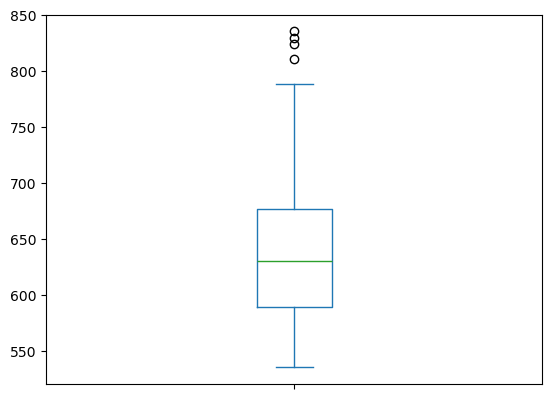

In [134]:
altitudes_ser.plot.box()

The altitude results look reasonable. Again, there are outliers in the data, but there is no reason to suspect that they represent incorrect values. As such, I'll replace the current `stations_df['altitude']` with the Series constructude just above.

In [143]:
tmp = stations_df.copy()
tmp['altitude'] = altitudes_ser
stations_df = tmp
del tmp

stations_df.head()

,station_id,name,latitude,longitude,altitude,slots,free_bikes,empty_slots
0,e1593acef03a0fd770595370586bc358,P31 - Estación Canal 13,-33.428334,-70.627312,599.0,13,6,7
1,3983dd515589a80338dd44a28f5ec414,V34 - Mestizo,-33.394000,-70.600000,655.0,23,8,15
2,405a3a5ca08c7536d3eb286cf8553025,V10 - Casa Costanera,-33.398000,-70.598000,653.0,11,8,3
3,0e8dfc3f137cb3911bd32f5fd45e0f93,V35 - Municipalidad de Vitacura,-33.398000,-70.601000,645.0,15,9,3
4,bdf4fc889476008ea8c644640f306bbc,V07 - Bicentenario,-33.401000,-70.602000,646.0,17,8,8


#### Validate data

I perform some basic, common-sense validation of the entries in my DataFrames. 

In [148]:
# Look for rows in stations_df that clearly contain invalid data.
filter =\
    (stations_df['latitude'] > 90) |\
    (stations_df['latitude'] < -90) |\
    (stations_df['longitude'] > 180) |\
    (stations_df['longitude'] < -180) |\
    (stations_df['slots'] < 0) |\
    (stations_df['free_bikes'] < 0) |\
    (stations_df['empty_slots'] < 0)

stations_df[filter].sum()

station_id       0
name             0
latitude       0.0
longitude      0.0
altitude       0.0
slots            0
free_bikes       0
empty_slots      0
dtype: object

In [154]:
filter =\
    (yelp_places_df['review_count'] < 0) |\
    (yelp_places_df['price'].str not in ['$', '$$', '$$$', '$$$$']) |\
    (yelp_places_df['rating']) < 1 |\
    (yelp_places_df['rating'] > 5) |\
    (yelp_places_df['distance'] < 0)

yelp_places_df[filter].sum()

yelp_id           0
name              0
review_count      0
price             0
rating          0.0
distance        0.0
station_id        0
dtype: object

Everythng looks reasonable!

#### Encode data

Finally, I'll encode `yelp_places_df['price']` as an integer between 1 and 4 inclusive.

In [181]:
def dollars_to_num(dollars: str) -> float:
    """
    Count the number of dollar signs in a string of stars.

    Usage examples:
    >>> dollars_to_num('$$$')
    3.0
    >>> dollars_to_num('')
    np.nan
    """
    allowed = ['', '$', '$$', '$$$', '$$$$']
    assert dollars in allowed,\
        f"expected string of dollar signs of max length 4, got '{dollars}'"

    return np.nan if dollars == '' else float(len(dollars))

In [184]:
tmp = yelp_places_df['price']\
    .fillna('')\
    .apply(dollars_to_num)
yelp_places_df['price'] = tmp
del tmp

## Export the cleaned data

I'll look over my tables one last time. If everything looks good, I'll export them to CSVs.

In [185]:
stations_df.sample(5)

,station_id,name,latitude,longitude,altitude,slots,free_bikes,empty_slots
70,961fadb450cb81b500afb4d88241eccc,LC020 - Manquehue Sur / Cristóbal Colón,-33.416947,-70.564646,682.0,11,8,3
210,268a84b54c366e65ddc8911c306c3320,LC096 - La Casona,-33.374901,-70.505181,835.0,11,7,4
176,39f0158ce045ebf24b48035d9d3751d8,LC031 - Presidente Errázuriz / Enrique Foster,-33.420735,-70.592328,646.0,10,2,6
63,dcfcd2a5e7544186c17316ef6414d0e6,LC017 - Sánchez Fontecilla / Cristóbal Colón,-33.426176,-70.590604,637.0,11,7,4
85,721b4bab82e0cb3b2eb8c24cb0710b30,LC093 - Los Estandartes,-33.408274,-70.583111,671.0,7,3,4


In [186]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   station_id   230 non-null    object 
 1   name         230 non-null    object 
 2   latitude     230 non-null    float64
 3   longitude    230 non-null    float64
 4   altitude     230 non-null    float64
 5   slots        230 non-null    int64  
 6   free_bikes   230 non-null    int64  
 7   empty_slots  230 non-null    int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 14.5+ KB


In [190]:
yelp_places_df.sample(5)

,yelp_id,name,review_count,price,rating,distance,station_id
2593,D9981RrXaRUVHvhGDoSxlQ,Ramblas,8,2.0,4.0,321.559661,95daa3b98d57eb58e75901158b4f60a2
5719,RBQmL2H6u8dqYsc92hID_Q,Burger Truck,4,2.0,3.0,520.474780,17db4c1637f146f9820d00e8a8a9f656
1641,Vs8LLb7gguxoW2fmDQrusQ,El Polluelo Amarillo,10,2.0,3.7,470.135459,0687a2ca2c61c5506bc5704be1368184
5056,_h00TokBWFQU_iCw9h_iuQ,Da Capo,1,NaN,3.0,1062.551756,31e869065ec137091d67dfc7b76bfcde
1448,37abvO0H2Fu4B_Q5oO5FCw,Arak - Club Libanés,3,2.0,3.3,95.628112,a547b3e5b959c26c2555219583d434d9


In [192]:
yelp_places_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10366 entries, 0 to 10365
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yelp_id       10366 non-null  object 
 1   name          10366 non-null  object 
 2   review_count  10366 non-null  int64  
 3   price         7007 non-null   float64
 4   rating        10366 non-null  float64
 5   distance      10366 non-null  float64
 6   station_id    10366 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 567.0+ KB


In [187]:
yelp_categories_df.sample(5)

,yelp_id,category_name
2507,-00_eG7huro3ki2QN-wvWA,creperies
4532,Cav1FmkZx_JK0N4b6ZdqNQ,sushi bars
9473,DenhpEaJts1HfBdDKoIscA,sushi bars
1389,6bIDOE9W3hrCAfvEz1gvXA,mexican
5180,KFLAdm2RJZtuoJ9y95bgqQ,chinese


In [189]:
yelp_categories_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2480 entries, 0 to 15147
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   yelp_id        2480 non-null   object
 1   category_name  2480 non-null   object
dtypes: object(2)
memory usage: 58.1+ KB


Seeing no obvious issues:

In [193]:
export(stations_df, 'stations_clean.csv')
export(yelp_places_df, 'yelp_places_clean.csv')
export(yelp_categories_df, 'yelp_categories_clean.csv')